# Optimal lumped mass matrix for the FEM

In [1]:
from __future__ import division
from sympy import *
from sympy import symbols
from sympy.matrices import *
import numpy as np

r, s, t, x, y, z, lamda = symbols('r s t x y z lambda') 
init_printing()

In [2]:
def mat_fun(M, fun):
    """Compute the matrix-function for M
    
    Parameters
    ----------
    M : (n,n) matrix
        (Invertible) Square matrix.
    fun : Python function
        Function to be applied to the matrix.
    
    >>> print mat_fun(M, exp) - exp(M)
    Matrix([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]])
    """
    sol = M.eigenvects()
    vals = zeros(8)
    vecs = zeros(8)

    cont = 0
    for i in range(len(sol)):
        for k in range(sol[i][1]):
            vals[cont, cont] = fun(sol[i][0])
            vecs[:, cont] = sol[i][2][k]
            cont = cont + 1
    
    return vecs*vals*vecs.inv()

In [3]:
def mat_norm(A):
    r"""Compute the norm of a matrix
    
    The norm is given by
    .. math::
        \Vert A\Vert = [\text{tr}{A^T A}]^{1/2}
   
    Parameters
    ----------
    A : (n,n) Matrix
        Real matrix.

    Returns
    -------
    norm : nonnegative
        Norm of the matrix.

    """
    
    norm = sqrt((A.T*A).trace())
    return simplify(norm)

In [4]:
def mat_dist(A, B, dist="frob"):
    r"""Compute the distant function for the tensor `A` and `B`

    The distance functions are
    
    .. math::
        \begin{align}
        &d_F(A,B) = \Vert A - B\Vert\\
        &d_L(A,B) = \Vert \log{A} - \log{B}\Vert\\
        &d_R(A,B) = \Vert \log{A^{-1/2}BA^{1/2}}\Vert
        \end{align}

    where :math:`\Vert M\Vert = [\text{tr}{M^T M}]^{1/2}`. 

    References
    ----------
    .. [1] Norris, Andrew. "The isotropic material closest to a given
        anisotropic material." Journal of Mechanics of Materials and
        Structures 1.2 (2006): 223-238.

    .. [2] Moakher, Maher, and Andrew N. Norris. "The closest elastic
        tensor of arbitrary symmetry to an elasticity tensor of lower
        symmetry." Journal of Elasticity 85.3 (2006): 215-263.

    """

    if dist=="frob":
        C = A - B

    if dist=="riemman":  # This is too slow
        C = B*mat_fun(A, sqrt)
        C = mat_fun(A, lambda x: S(1)/sqrt(x))*C
        C = mat_fun(C, log)
        
    if dist=="log":
        C = mat_fun(A, log) -  mat_fun(B, log)
    
    return  mat_norm(C)

The mass matrix is computed below

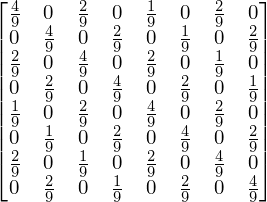

In [5]:
Nfun = S(1)/4*Matrix([(1 + r)*(1 + s),
         (1 - r)*(1 + s),
         (1 - r)*(1 - s),
         (1 + r)*(1 - s)])

H = zeros(2,8)
for i in range(4):
    H[0, 2*i] = Nfun[i]
    H[1, 2*i + 1] = Nfun[i]

    
M_int = H.T*H

M = zeros(8,8)
for i in range(8):
    for j in range(8):
        M[i,j] = integrate(M_int[i,j],(r,-1,1), (s,-1,1))

M

In [6]:
Ms = symbols('M0:%d'%8)

def f(i,j):
    if i == j:
        return Ms[i]
    else:
        return 0
    
M_diag = Matrix(8, 8, f)

## Frobenius norm

In [7]:
dist_sq = mat_dist(M_diag, M)**2

In [8]:
grad = [diff(dist_sq, x) for x in Ms]

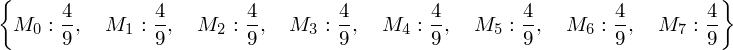

In [9]:
solve(grad, Ms)

## Log-Euclidean norm

In [10]:
dist_sq = mat_dist(M_diag, M, dist='log')**2

In [11]:
grad = [diff(dist_sq, x) for x in Ms]

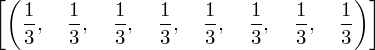

In [12]:
solve(grad, Ms)

## Constrained optimization

In [13]:
f = mat_dist(M_diag, M)**2 + lamda*(8 - sum(Ms))

var = list(Ms)
var.append(lamda)

In [14]:
grad = [diff(f, x) for x in var]

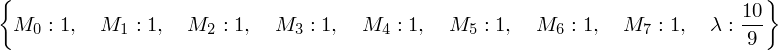

In [15]:
solve(grad, var)